# Test Gaussian fits to MCMC chains


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy import optimize
from lace_manager.sampler import emcee_sampler
from lace_manager.likelihood import marg_p1d_like

### Load a file containing the relevant parameters from a MCMC chain

In [2]:
simple_igm=False
if simple_igm:
    fname='chain_igm_1.npz'
else:
    fname='chain_igm_8.npz'

In [3]:
# true values for central simulation
true_D2_star=0.34655
true_n_star=-2.297

In [4]:
data=np.load(fname)
x=data['Delta2_star']
y=data['n_star']
lnprob=data['lnprob']
# get rid of low-probability islands
max_lnprob=np.max(lnprob)
delta_lnprob_cut=50
if delta_lnprob_cut:
    mask=(max_lnprob-lnprob<delta_lnprob_cut)
    print('will use {} / {} points'.format(np.sum(mask),len(lnprob)))
    x=x[mask]
    y=y[mask]
    lnprob=lnprob[mask]
prob=np.exp(lnprob-max_lnprob)

will use 448354 / 454400 points


In [5]:
# print parameter range
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
print('{:.3f} < Delta2_star < {:.3f}'.format(xmin,xmax))
print('{:.3f} < n_star < {:.3f}'.format(ymin,ymax))

0.282 < Delta2_star < 0.422
-2.344 < n_star < -2.256


### Compute mean, covariance

In [6]:
mean_D2_star=np.mean(x)
mean_n_star=np.mean(y)
print('Delta2_star (mean) =',mean_D2_star)
print('n_star (mean) =',mean_n_star)

Delta2_star (mean) = 0.3495996918358275
n_star (mean) = -2.3008833904275847


In [7]:
rms_D2_star=np.std(x)
rms_n_star=np.std(y)
print('Delta2_star (rms) =',rms_D2_star)
print('n_star (rms) =',rms_n_star)

Delta2_star (rms) = 0.013856180360762272
n_star (rms) = 0.009266524022418683


### Compute media and MAD, more robust to outliers

In [8]:
med_D2_star=np.median(x)
med_n_star=np.median(y)
print('Delta2_star (median) =',med_D2_star)
print('n_star (median) =',med_n_star)

Delta2_star (median) = 0.3493880010998904
n_star (median) = -2.3025672512599296


In [9]:
std_mad_D2_star=1.4826*stats.median_abs_deviation(x)
std_mad_n_star=1.4826*stats.median_abs_deviation(y)
print('Delta2_star (std_mad) =',std_mad_D2_star)
print('n_star (std_mad) =',std_mad_n_star)

Delta2_star (std_mad) = 0.013347696698299284
n_star (std_mad) = 0.008097876724314461


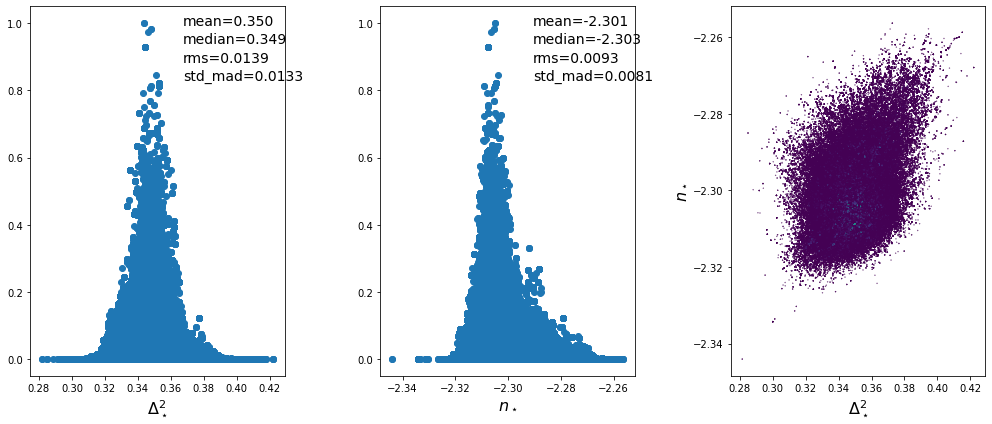

In [10]:
fig, axs = plt.subplots(1,3,figsize=(14,6),sharey=False)
axs[0].scatter(x,prob)
axs[0].set_xlabel(r'$\Delta^2_\star$',fontsize=16)
axs[0].annotate('mean={:.3f}'.format(mean_D2_star),xy=(0.6,0.95),xycoords='axes fraction',fontsize=14)
axs[0].annotate('median={:.3f}'.format(med_D2_star),xy=(0.6,0.9),xycoords='axes fraction',fontsize=14)
axs[0].annotate('rms={:.4f}'.format(rms_D2_star),xy=(0.6,0.85),xycoords='axes fraction',fontsize=14)
axs[0].annotate('std_mad={:.4f}'.format(std_mad_D2_star),xy=(0.6,0.8),xycoords='axes fraction',fontsize=14)
axs[1].scatter(y,prob)
axs[1].set_xlabel(r'$n_\star$',fontsize=16)
axs[1].annotate('mean={:.3f}'.format(mean_n_star),xy=(0.6,0.95),xycoords='axes fraction',fontsize=14)
axs[1].annotate('median={:.3f}'.format(med_n_star),xy=(0.6,0.9),xycoords='axes fraction',fontsize=14)
axs[1].annotate('rms={:.4f}'.format(rms_n_star),xy=(0.6,0.85),xycoords='axes fraction',fontsize=14)
axs[1].annotate('std_mad={:.4f}'.format(std_mad_n_star),xy=(0.6,0.8),xycoords='axes fraction',fontsize=14)
axs[2].scatter(x,y,c=prob,s=0.1)
axs[2].set_xlabel(r'$\Delta^2_\star$',fontsize=16)
axs[2].set_ylabel(r'$n_\star$',fontsize=16);
plt.tight_layout()
plt.savefig('hist_{}.png'.format(delta_lnprob_cut))

# Derive a robust Gaussian fit 

In [11]:
def get_correlation(delta_lnprob_cut=20):
    cut_lnprob=max_lnprob-delta_lnprob_cut
    mask=lnprob>cut_lnprob
    xx=x[mask]
    yy=y[mask]
    return np.corrcoef(xx,yy)

In [12]:
max_lnprob=np.max(lnprob)
imax=np.where(lnprob==max_lnprob)
max_like_D2_star=x[imax][0]
max_like_n_star=y[imax][0]
print('Delta2_star (max like) =',max_like_D2_star)
print('n_star (max like) =',max_like_n_star)

Delta2_star (max like) = 0.34401205489811976
n_star (max like) = -2.3051506835424913


In [13]:
# check that correlation coefficient is robust
print('cut -> corr coeff')
for cut in [5,20,50,100,500]:
    corr=get_correlation(cut)
    print('{} -> {:.3f}'.format(cut,corr[0,1]))

cut -> corr coeff
5 -> 0.353
20 -> 0.367
50 -> 0.367
100 -> 0.367
500 -> 0.367


In [14]:
def fit_gaussian(median_delta_lnprob_cut=50, corr_delta_lnprob_cut=20):
    # get correlation matrix using points only near the peak
    corr=get_correlation(corr_delta_lnprob_cut)
    # use more points to compute the median and MAD
    cut_lnprob=max_lnprob-median_delta_lnprob_cut
    mask=lnprob>cut_lnprob
    xx=x[mask]
    yy=y[mask]
    # compute (robust) mean and std
    mean=np.array([np.median(x),np.median(y)])
    #print('Delta2_star (median) =',mean[0])
    #print('n_star (median) =',mean[1])
    # estimate rms with MAD
    rms_x=1.4826*stats.median_abs_deviation(x)
    rms_y=1.4826*stats.median_abs_deviation(y)
    #print('Delta2_star (std_mad) =',rms_x)
    #print('n_star (std_mad) =',rms_y)
    # scale covariance with correlation matrix
    rms=np.array([rms_x,rms_y])
    cov=(rms*corr).transpose()*rms
    return mean, cov

In [15]:
# check that estimation of mean via median is robust
print('cut -> param_median')
for cut in [20, 50, 100, 500]:
    mean,cov=fit_gaussian(median_delta_lnprob_cut=cut)
    print('{} -> {:.4f}, {:.4f}'.format(cut,mean[0],mean[1]))

cut -> param_median
20 -> 0.3494, -2.3026
50 -> 0.3494, -2.3026
100 -> 0.3494, -2.3026
500 -> 0.3494, -2.3026


In [16]:
# check that estimation of rms via MAD is robust
print('cut -> param_rms')
for cut in [20, 50, 100, 500]:
    mean,cov=fit_gaussian(median_delta_lnprob_cut=cut)
    rms=np.sqrt(cov.diagonal())
    print('{} -> {:.4f}, {:.4f}'.format(cut,rms[0],rms[1]))

cut -> param_rms
20 -> 0.0133, 0.0081
50 -> 0.0133, 0.0081
100 -> 0.0133, 0.0081
500 -> 0.0133, 0.0081


# Compare chain and Gaussian fit 

In [17]:
# actual Gaussian fit to use
mean,cov=fit_gaussian(median_delta_lnprob_cut=50)
invcov=np.linalg.inv(cov)
rms=np.sqrt(cov.diagonal())

In [18]:
def gauss_log_like(D2_star,n_star,mean,invcov):
    diff=np.array([D2_star-mean[0],n_star-mean[1]])
    return -0.5*np.dot(np.dot(invcov,diff),diff)

In [19]:
# setup 2D grid
N=500
Nj=complex(0,N)
X, Y = np.mgrid[xmin:xmax:Nj, ymin:ymax:Nj]
# evaluate likelihood in 2D grid
log_like=np.array([gauss_log_like(D2,n,mean,invcov) for (D2,n) in zip(X.ravel(),Y.ravel())]).reshape(X.shape)
like=np.exp(log_like)

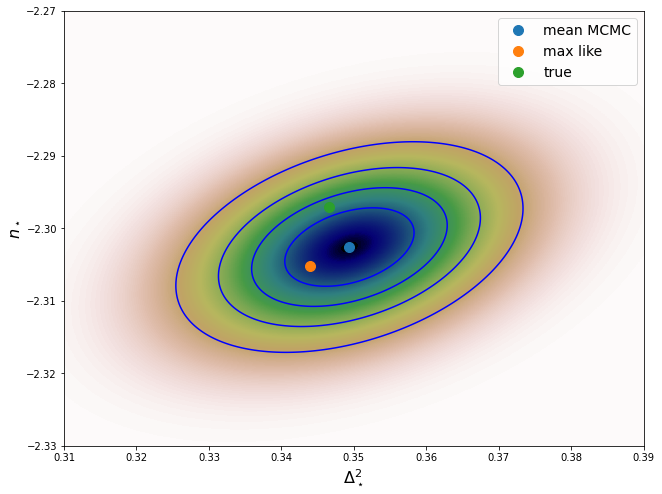

In [20]:
fig, ax = plt.subplots(1, 1,figsize=(12,8))
if simple_igm:
    #ax.plot(x, y, 'k.', markersize=0.2)
    ax.set_xlim(0.325,0.365)
    ax.set_ylim(-2.31,-2.29)
else:
    #ax.plot(x, y, 'k.', markersize=0.1)
    ax.set_xlim(0.31,0.39)
    ax.set_ylim(-2.33,-2.27)
ax.imshow(np.rot90(like),cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])
ax.contour(X,Y,like,5,colors='b')
ax.plot(mean[0],mean[1],'o',markersize=10,label='mean MCMC')
ax.plot(max_like_D2_star,max_like_n_star,'o',markersize=10,label='max like')
ax.plot(true_D2_star,true_n_star,'o',markersize=10,label='true')
ax.legend(fontsize=14)
ax.set_xlabel(r'$\Delta^2_\star$',fontsize=16)
ax.set_ylabel(r'$n_\star$',fontsize=16);
plt.show()

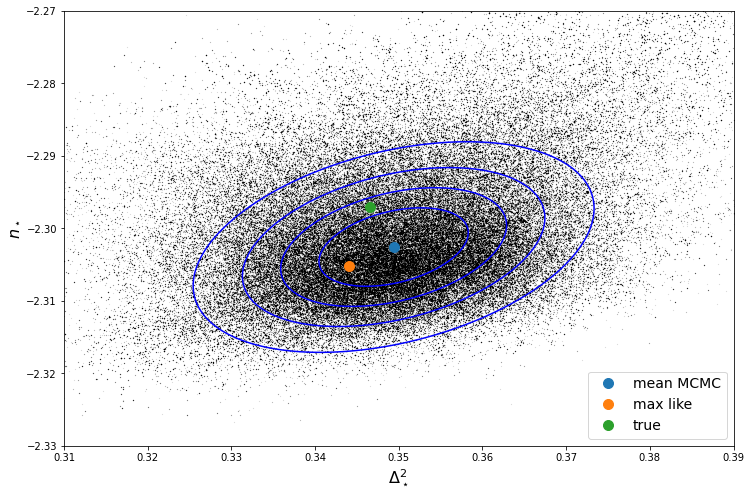

In [21]:
fig, ax = plt.subplots(1, 1,figsize=(12,8))
if simple_igm:
    ax.plot(x, y, 'k.', markersize=0.2)
    ax.set_xlim(0.325,0.365)
    ax.set_ylim(-2.31,-2.29)
else:
    ax.plot(x, y, 'k.', markersize=0.1)
    ax.set_xlim(0.31,0.39)
    ax.set_ylim(-2.33,-2.27)
#ax.imshow(np.rot90(like),cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])
ax.contour(X,Y,like,5,colors='b')
ax.plot(mean[0],mean[1],'o',markersize=10,label='mean MCMC')
ax.plot(max_like_D2_star,max_like_n_star,'o',markersize=10,label='max like')
ax.plot(true_D2_star,true_n_star,'o',markersize=10,label='true')
ax.legend(fontsize=14)
ax.set_xlabel(r'$\Delta^2_\star$',fontsize=16)
ax.set_ylabel(r'$n_\star$',fontsize=16);
plt.show()

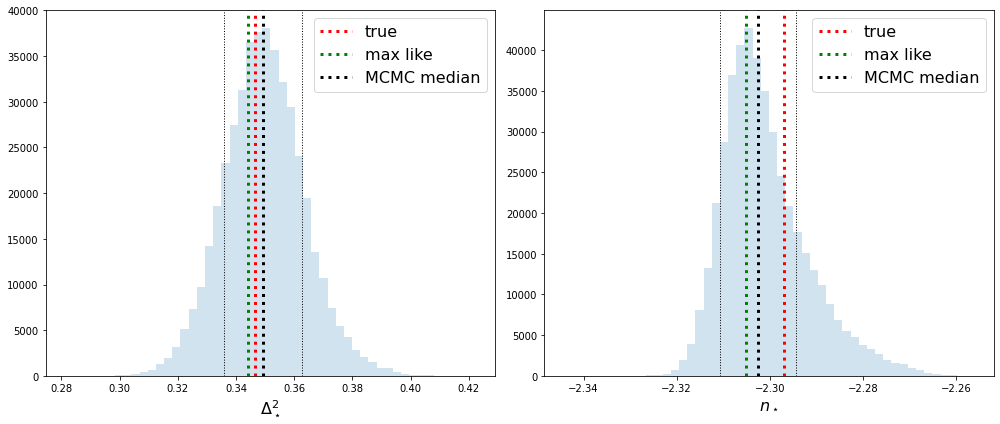

In [22]:
fig, axs = plt.subplots(1,2,figsize=(14,6),sharey=False)
_=axs[0].hist(x,bins=50,alpha=0.2)
axs[0].set_xlabel(r'$\Delta^2_\star$',fontsize=16)
axs[0].axvline(x=true_D2_star,ls=':',color='red',lw=3,label='true')
axs[0].axvline(x=max_like_D2_star,ls=':',color='green',lw=3,label='max like')
axs[0].axvline(x=mean[0]-rms[0],ls=':',color='black',lw=1)
axs[0].axvline(x=mean[0],ls=':',color='black',lw=3,label='MCMC median')
axs[0].axvline(x=mean[0]+rms[0],ls=':',color='black',lw=1)
axs[0].legend(fontsize=16)
_=axs[1].hist(y,bins=50,alpha=0.2)
axs[1].set_xlabel(r'$n_\star$',fontsize=16)
axs[1].axvline(x=true_n_star,ls=':',color='red',lw=3,label='true')
axs[1].axvline(x=max_like_n_star,ls=':',color='green',lw=3,label='max like')
axs[1].axvline(x=mean[1]-rms[1],ls=':',color='black',lw=1)
axs[1].axvline(x=mean[1],ls=':',color='black',lw=3,label='MCMC median')
axs[1].axvline(x=mean[1]+rms[1],ls=':',color='black',lw=1)
axs[1].legend(fontsize=16)
plt.tight_layout()
plt.savefig('hist_{}.png'.format(delta_lnprob_cut))